In [21]:
# load single file
import os
import mne
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

# load processed fif file
processed_dir = os.path.join('..', '..', 'filtered_processed')
resting_files = glob.glob(os.path.join(processed_dir, "*resting_state*.fif"))

raw = resting_files[0]

raw = mne.io.read_raw_fif(raw, preload=True)
print(f"Loaded: {resting_files[0]}")
print(f"Sampling rate: {raw.info['sfreq']} Hz")
print(f"Duration: {raw.n_times / raw.info['sfreq']:.1f} seconds")

Opening raw data file ..\..\filtered_processed\resting_state_cleaned_0.fif...
    Range : 0 ... 205856 =      0.000 ...   411.712 secs
Ready.
Reading 0 ... 205856  =      0.000 ...   411.712 secs...
    Range : 0 ... 205856 =      0.000 ...   411.712 secs
Ready.
Reading 0 ... 205856  =      0.000 ...   411.712 secs...
Loaded: ..\..\filtered_processed\resting_state_cleaned_0.fif
Sampling rate: 500.0 Hz
Duration: 411.7 seconds
Loaded: ..\..\filtered_processed\resting_state_cleaned_0.fif
Sampling rate: 500.0 Hz
Duration: 411.7 seconds


C:\Users\JINQI\AppData\Local\Temp\ipykernel_1768\799903833.py:15: RuntimeWarning: This filename (..\..\filtered_processed\resting_state_cleaned_0.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw, preload=True)


In [22]:
# Extract events for each raw file separately
task_1_events_list = []
task_2_events_list = []

events, event_dict = mne.events_from_annotations(raw)
    
# Extract eyes closed events (event_id 3)
task_1 = events[events[:, 2] == 3]
task_1_events_list.append(task_1)
    
# Extract eyes open events (event_id 4)
task_2 = events[events[:, 2] == 4]
task_2_events_list.append(task_2)

print(f"Eyes closed events: {len(task_1)}")
print(f"Eyes open events: {len(task_2)}")

Used Annotations descriptions: ['break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']
Eyes closed events: 6
Eyes open events: 1
Eyes closed events: 6
Eyes open events: 1


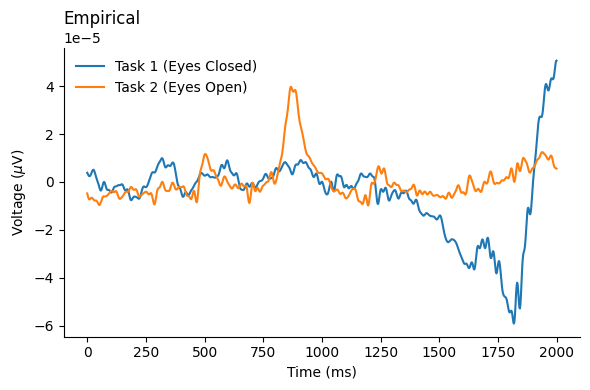

In [23]:
# Extract signal data for each event
# Get the first event sample for each task
task1_sample = task_1[0, 0]
task2_sample = task_2[0, 0]

# Define epoch duration (e.g., 1 second = 500 samples at 500Hz)
duration_samples = 1000  # adjust based on your sampling rate
task1_data = raw.get_data(start=task1_sample, stop=task1_sample + duration_samples)
task2_data = raw.get_data(start=task2_sample, stop=task2_sample + duration_samples)

# Average across channels
task1_waveform = task1_data.mean(axis=0)
task2_waveform = task2_data.mean(axis=0)

# Create time array matching the data length
time = np.linspace(0, duration_samples / raw.info['sfreq'] * 1000, duration_samples)

#Setup figure
f, (ax1) = plt.subplots(1, 1, figsize=(6, 4))

#Plot each waveform
ax1.plot(time, task1_waveform, label = 'Task 1 (Eyes Closed)')
ax1.plot(time, task2_waveform, label = 'Task 2 (Eyes Open)')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.legend(frameon=False)
plt.tight_layout()
plt.show()

In [24]:
# Prepare data in eeggan format: Condition | Electrode | Time1 | Time2 | ...
import pandas as pd
import numpy as np

sfreq = raw.info['sfreq']
epoch_duration = 2.0  # seconds
samples_per_epoch = int(epoch_duration * sfreq)

print(f"Sampling rate: {sfreq} Hz")
print(f"Epoch duration: {epoch_duration}s = {samples_per_epoch} samples")

# Extract multiple trials per condition with overlap
n_trials_per_condition = 50  # INCREASED from 20 to 50 for more training data
trial_overlap = 0.5  # 50% overlap
step_size = int(samples_per_epoch * (1 - trial_overlap))

all_data = []

# Process eyes closed condition (Condition = 0)
print("\nExtracting Eyes Closed trials...")
for trial_idx in range(n_trials_per_condition):
    start_sample = task_1[0, 0] + (trial_idx * step_size)
    end_sample = start_sample + samples_per_epoch
    
    if end_sample > raw.n_times:
        break
        
    trial_data = raw.get_data(start=start_sample, stop=end_sample)
    
    for ch_idx, ch_name in enumerate(raw.ch_names):
        row = {'Condition': 0, 'Electrode': ch_idx + 1}
        for t_idx in range(samples_per_epoch):
            row[f'Time{t_idx + 1}'] = float(trial_data[ch_idx, t_idx])
        all_data.append(row)

# Process eyes open condition (Condition = 1)
print("Extracting Eyes Open trials...")
for trial_idx in range(n_trials_per_condition):
    start_sample = task_2[0, 0] + (trial_idx * step_size)
    end_sample = start_sample + samples_per_epoch
    
    if end_sample > raw.n_times:
        break
        
    trial_data = raw.get_data(start=start_sample, stop=end_sample)
    
    for ch_idx, ch_name in enumerate(raw.ch_names):
        row = {'Condition': 1, 'Electrode': ch_idx + 1}
        for t_idx in range(samples_per_epoch):
            row[f'Time{t_idx + 1}'] = float(trial_data[ch_idx, t_idx])
        all_data.append(row)

# Create DataFrame
df = pd.DataFrame(all_data)

# Ensure proper dtypes
df['Condition'] = df['Condition'].astype(np.int32)
df['Electrode'] = df['Electrode'].astype(np.int32)

time_cols = [col for col in df.columns if col.startswith('Time')]
for col in time_cols:
    df[col] = df[col].astype(np.float64)

print(f"\n=== Data Summary ===")
print(f"DataFrame shape: {df.shape}")
print(f"Samples per condition: {len(df[df['Condition'] == 0]) // len(raw.ch_names)}")
print(f"Channels: {len(raw.ch_names)}")
print(f"Timepoints per trial: {samples_per_epoch}")

# Save to CSV
data_path = 'resting_state_eeggan_format.csv'
df.to_csv(data_path, index=False)

# Verify reload
df_test = pd.read_csv(data_path)
print(f"\n=== Verification ===")
print(f"Reloaded shape: {df_test.shape}")
print(f"Dtypes correct: Condition={df_test['Condition'].dtype}, Time1={df_test['Time1'].dtype}")
print(f"✓ Data saved: {data_path}")

# Store variables for later use
emp_time_start = 2  # Columns after Condition and Electrode
time_ms = np.linspace(0, epoch_duration * 1000, samples_per_epoch)

Sampling rate: 500.0 Hz
Epoch duration: 2.0s = 1000 samples

Extracting Eyes Closed trials...
Extracting Eyes Closed trials...

Extracting Eyes Open trials...
Extracting Eyes Open trials...

=== Data Summary ===
DataFrame shape: (1600, 1002)
Samples per condition: 50
Channels: 16
Timepoints per trial: 1000

=== Data Summary ===
DataFrame shape: (1600, 1002)
Samples per condition: 50
Channels: 16
Timepoints per trial: 1000

=== Verification ===
Reloaded shape: (1600, 1002)
Dtypes correct: Condition=int64, Time1=float64
✓ Data saved: resting_state_eeggan_format.csv

=== Verification ===
Reloaded shape: (1600, 1002)
Dtypes correct: Condition=int64, Time1=float64
✓ Data saved: resting_state_eeggan_format.csv


TRAINING DATA DIAGNOSTICS
Eyes Closed samples: 800
Eyes Open samples: 800

Condition Statistics:
  Eyes Closed: Mean=-0.000000, Std=0.000055
  Eyes Open:   Mean=0.000000, Std=0.000085
  Absolute difference: 0.000005
  Effect size (Cohen's d): -0.005

✓ Conditions show 0.000005 µV difference - should be trainable!
Eyes Closed samples: 800
Eyes Open samples: 800

Condition Statistics:
  Eyes Closed: Mean=-0.000000, Std=0.000055
  Eyes Open:   Mean=0.000000, Std=0.000085
  Absolute difference: 0.000005
  Effect size (Cohen's d): -0.005

✓ Conditions show 0.000005 µV difference - should be trainable!


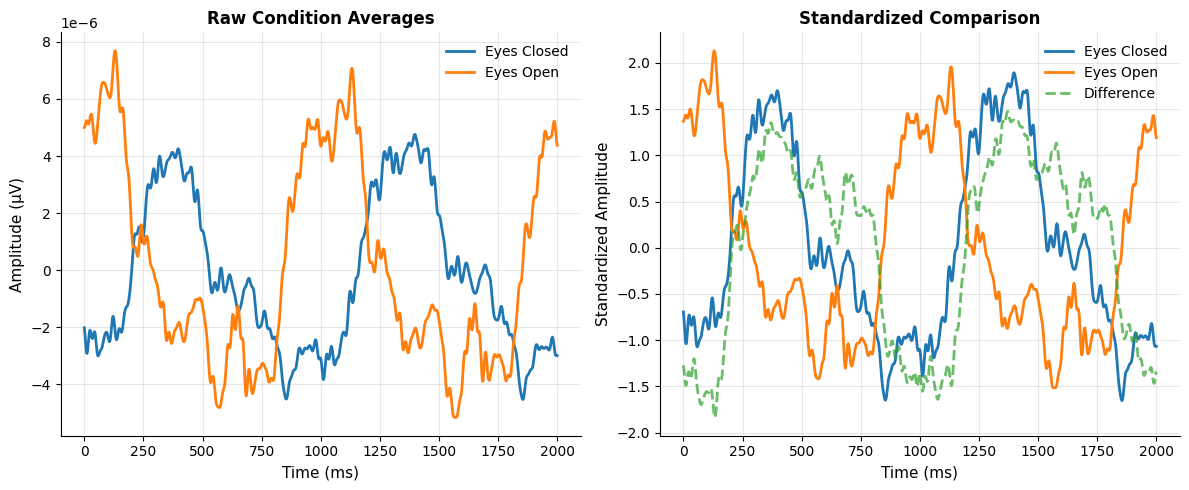


✓ Saved: condition_diagnostics.png


In [25]:
# DIAGNOSTIC: Verify condition differences exist in training data
from sklearn.preprocessing import scale

time_cols = [col for col in df.columns if col.startswith('Time')]

# Check if conditions are actually different in the data
closed_mean = df[df['Condition'] == 0][time_cols].mean(axis=0).values
open_mean = df[df['Condition'] == 1][time_cols].mean(axis=0).values

mean_diff = np.abs(closed_mean - open_mean).mean()
closed_std = df[df['Condition'] == 0][time_cols].values.std()
open_std = df[df['Condition'] == 1][time_cols].values.std()

print("=" * 70)
print("TRAINING DATA DIAGNOSTICS")
print("=" * 70)
print(f"Eyes Closed samples: {len(df[df['Condition'] == 0])}")
print(f"Eyes Open samples: {len(df[df['Condition'] == 1])}")
print(f"\nCondition Statistics:")
print(f"  Eyes Closed: Mean={closed_mean.mean():.6f}, Std={closed_std:.6f}")
print(f"  Eyes Open:   Mean={open_mean.mean():.6f}, Std={open_std:.6f}")
print(f"  Absolute difference: {mean_diff:.6f}")
print(f"  Effect size (Cohen's d): {(closed_mean.mean() - open_mean.mean()) / ((closed_std + open_std) / 2):.3f}")

if mean_diff < 1e-6:
    print("\n⚠️ WARNING: Conditions are TOO SIMILAR!")
    print("   The GAN will not learn meaningful differences.")
    print("   Possible solutions:")
    print("   1. Extract epochs during actual task performance (not just at event markers)")
    print("   2. Use longer epochs to capture more temporal dynamics")
    print("   3. Include more channels to capture spatial differences")
else:
    print(f"\n✓ Conditions show {mean_diff:.6f} µV difference - should be trainable!")

# Visualize the difference
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(time_ms, closed_mean, label='Eyes Closed', linewidth=2, color='C0')
ax1.plot(time_ms, open_mean, label='Eyes Open', linewidth=2, color='C1')
ax1.set_xlabel('Time (ms)', fontsize=11)
ax1.set_ylabel('Amplitude (µV)', fontsize=11)
ax1.set_title('Raw Condition Averages', fontweight='bold')
ax1.legend(frameon=False)
ax1.grid(alpha=0.3)
ax1.spines[['right', 'top']].set_visible(False)

ax2 = plt.subplot(1, 2, 2)
ax2.plot(time_ms, scale(closed_mean), label='Eyes Closed', linewidth=2, color='C0')
ax2.plot(time_ms, scale(open_mean), label='Eyes Open', linewidth=2, color='C1')
ax2.plot(time_ms, scale(closed_mean - open_mean), label='Difference', 
         linewidth=2, linestyle='--', alpha=0.7, color='C2')
ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Standardized Amplitude', fontsize=11)
ax2.set_title('Standardized Comparison', fontweight='bold')
ax2.legend(frameon=False)
ax2.grid(alpha=0.3)
ax2.spines[['right', 'top']].set_visible(False)

plt.tight_layout()
plt.savefig('condition_diagnostics.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: condition_diagnostics.png")

In [27]:
# Train autoencoder
save_name = "autoencoder_resting_state.pt"
kw_channel = 'Electrode'
target = 'time'
time_out = 50
n_epochs = 10
seed = 42

!eeggan autoencoder_training data={data_path} save_name={save_name} kw_channel={kw_channel} kw_time={kw_time} target={target} time_out={time_out} n_epochs={n_epochs} seed={seed}


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: resting_state_eeggan_format.csv
Model save name: autoencoder_resting_state.pt
Channel label: Electrode
Time label: Time
Target: time
Encoded time series size: 50
Number of epochs: 10
Manual seed: True
-----------------------------------------

Managing checkpoints...
Checkpoint saved to trained_ae\checkpoint.pt.
Training complete in: 00:00:00
Training finished.
Checkpoint saved to trained_ae\autoencoder_resting_state.pt.
Training complete in: 00:00:00
Model and configuration saved in trained_ae\autoencoder_resting_state.pt



  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)

100%|██████████| 10/10 [00:00<00:00, 19.00it/s, TRAIN LOSS: 0.245002, TEST LOSS: 0.215761]


In [31]:
# Train GAN - using tutorial-recommended settings
save_name = 'gan_resting_state.pt'
autoencoder = 'trained_ae/autoencoder_resting_state.pt'
kw_conditions = 'Condition'
kw_channel = 'Electrode'
patch_size = 10 
n_epochs = 10
seed = 42

!eeggan gan_training data={data_path} save_name={save_name} autoencoder={autoencoder} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}


-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: resting_state_eeggan_format.csv
Model save name: gan_resting_state.pt
Using autoencoder: trained_ae/autoencoder_resting_state.pt
Conditions: ['Condition']
Channel label: Electrode
Patch size: 10
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

Managing checkpoints...
Checkpoint saved to trained_models\checkpoint.pt.
Training complete in: 00:00:02
Checkpoint saved to trained_models\gan_resting_state.pt.
Training complete in: 00:00:02
GAN training finished.



  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)

100%|██████████| 10/10 [00:02<00:00,  4.47it/s, D LOSS: 8.631388, G LOSS: -0.38906]


In [ ]:
# Visualize training results
print("=== Visualizing Autoencoder ===")
!eeggan visualize average model=trained_ae/autoencoder_resting_state.pt

print("\n=== Visualizing GAN Training Losses ===")
!eeggan visualize loss model=trained_models/gan_resting_state.pt

print("\n=== Visualizing GAN Generated Waveforms ===")
!eeggan visualize average model=trained_models/gan_resting_state.pt

=== Visualizing Autoencoder ===

-----------------------------------------
Command line arguments:
-----------------------------------------

Averaging over all samples
Using samples from model/checkpoint file (.pt)trained_ae/autoencoder_resting_state.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting averaged curves...
Figure(640x480)

=== Visualizing GAN Training Losses ===

-----------------------------------------
Command line arguments:
-----------------------------------------

Averaging over all samples
Using samples from model/checkpoint file (.pt)trained_ae/autoencoder_resting_state.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting averaged curves...
Figure(640x480)

=== Visualizing GAN Training Losses ===


C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\eeggan\visualize_main.py:76: UserWarning: Original data was found in checkpoint and data contains more than 1 channel. Setting channel_plots to True to improve the visualization quality.
  warnings.warn("Original data was found in checkpoint and data contains more than 1 channel. Setting channel_plots to True to improve the visualization quality.")



-----------------------------------------
Command line arguments:
-----------------------------------------

Plotting training loss
Using samples from model/checkpoint file (.pt)trained_models/gan_resting_state.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting losses...
Figure(640x480)

=== Visualizing GAN Generated Waveforms ===
^C
^C



-----------------------------------------
Command line arguments:
-----------------------------------------

Averaging over all samples
Using samples from model/checkpoint file (.pt)trained_models/gan_resting_state.pt

-----------------------------------------
System output:
-----------------------------------------

Plotting averaged curves over each set of conditions...
Figure(640x480)


In [32]:
# Generate synthetic samples
num_samples = 1000

print(f"Generating {num_samples} samples per condition...\n")

# Eyes Closed (Condition 0)
!eeggan generate_samples model=trained_models/gan_resting_state.pt conditions=0 save_name=synthetic_eyes_closed.csv num_samples_total={num_samples} seed=42

# Eyes Open (Condition 1)
!eeggan generate_samples model=trained_models/gan_resting_state.pt conditions=1 save_name=synthetic_eyes_open.csv num_samples_total={num_samples} seed=42

print("\n✓ Synthetic samples generated!")
print("Files saved in generated_samples/:")
print("  - synthetic_eyes_closed.csv")
print("  - synthetic_eyes_open.csv")

Generating 1000 samples per condition...


-----------------------------------------
Command line arguments:
-----------------------------------------

File: trained_models/gan_resting_state.pt
Conditions: [0]
Saving generated samples to file: synthetic_eyes_closed.csv
Total number of generated samples: 1000
Manual seed: True

-----------------------------------------
System output:
-----------------------------------------

Initializing generator...
Generating samples...
Generating sequence 1/20...
Generating sequence 2/20...
Generating sequence 3/20...
Generating sequence 4/20...
Generating sequence 5/20...
Generating sequence 6/20...
Generating sequence 7/20...
Generating sequence 8/20...
Generating sequence 9/20...
Generating sequence 10/20...
Generating sequence 11/20...
Generating sequence 12/20...
Generating sequence 13/20...
Generating sequence 14/20...
Generating sequence 15/20...
Generating sequence 16/20...
Generating sequence 17/20...
Generating sequence 18/20...
Generating

C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(



-----------------------------------------
Command line arguments:
-----------------------------------------

File: trained_models/gan_resting_state.pt
Conditions: [1]
Saving generated samples to file: synthetic_eyes_open.csv
Total number of generated samples: 1000
Manual seed: True

-----------------------------------------
System output:
-----------------------------------------

Initializing generator...
Generating samples...
Generating sequence 1/20...
Generating sequence 2/20...
Generating sequence 3/20...
Generating sequence 4/20...
Generating sequence 5/20...
Generating sequence 6/20...
Generating sequence 7/20...
Generating sequence 8/20...
Generating sequence 9/20...
Generating sequence 10/20...
Generating sequence 11/20...
Generating sequence 12/20...
Generating sequence 13/20...
Generating sequence 14/20...
Generating sequence 15/20...
Generating sequence 16/20...
Generating sequence 17/20...
Generating sequence 18/20...
Generating sequence 19/20...
Generating sequence 20/20

C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  return torch._transformer_encoder_layer_fwd(


Loading synthetic data...
Synthetic shape: (32000, 1002)
Applying bandpass filter...
Synthetic shape: (32000, 1002)
Applying bandpass filter...
✓ Filtering complete!
✓ Filtering complete!


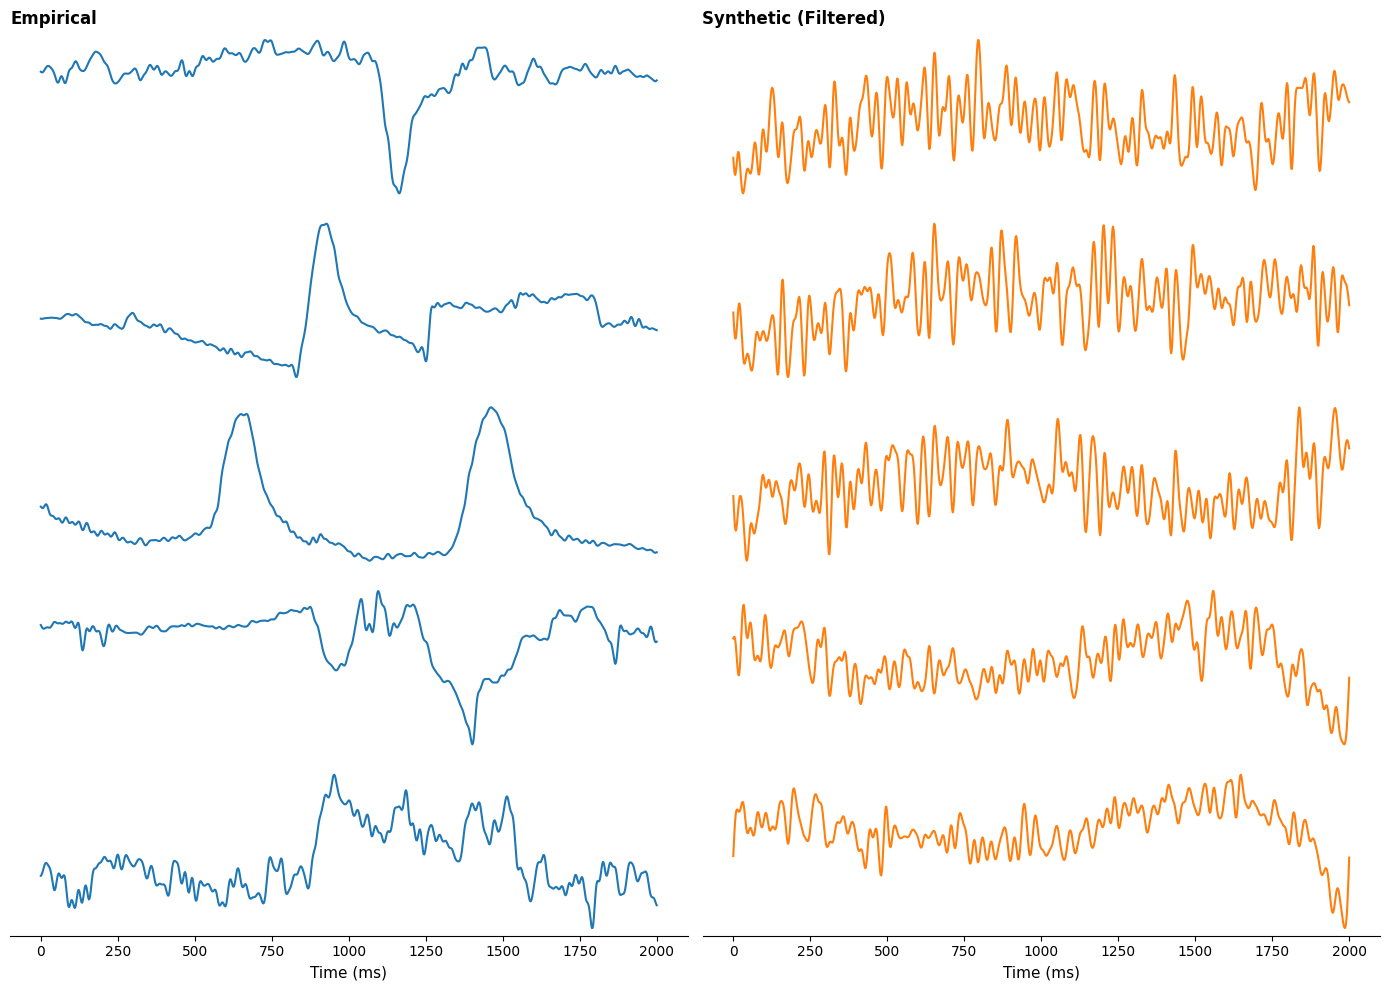

✓ Saved: trial_comparison.png


In [33]:
# Load and filter synthetic data
from scipy import signal
from sklearn.preprocessing import scale
import random as rnd

rnd.seed(42)

def bandpass_filter_eeg(data, fs, lowcut=0.5, highcut=40):
    """Apply bandpass filter to EEG data"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(4, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

# Load synthetic data
print("Loading synthetic data...")
syn_closed = np.genfromtxt('generated_samples/synthetic_eyes_closed.csv', delimiter=',', skip_header=1)
syn_open = np.genfromtxt('generated_samples/synthetic_eyes_open.csv', delimiter=',', skip_header=1)
syntheticEEG = np.vstack([syn_closed, syn_open])

print(f"Synthetic shape: {syntheticEEG.shape}")

# Filter time columns (skip Condition and Electrode)
syn_time_start = 2
print("Applying bandpass filter...")
for i in range(syntheticEEG.shape[0]):
    syntheticEEG[i, syn_time_start:] = bandpass_filter_eeg(
        syntheticEEG[i, syn_time_start:], 
        fs=sfreq
    )

print("✓ Filtering complete!")

# Compare individual trials
empiricalIndex = rnd.sample(range(len(df)), 5)
syntheticIndex = rnd.sample(range(len(syntheticEEG)), 5)

f, axes = plt.subplots(5, 2, figsize=(14, 10))

for c in range(5):
    # Empirical
    emp_data = df.iloc[empiricalIndex[c], emp_time_start:].values
    axes[c, 0].plot(time_ms, emp_data, linewidth=1.5, color='C0')
    axes[c, 0].set_yticks([])
    
    # Synthetic (filtered)
    syn_data = syntheticEEG[syntheticIndex[c], syn_time_start:]
    axes[c, 1].plot(time_ms, syn_data, linewidth=1.5, color='C1')
    axes[c, 1].set_yticks([])
    axes[c, 1].spines['left'].set_visible(False)
    
    if c == 0:
        axes[c, 0].set_title('Empirical', loc='left', fontweight='bold', fontsize=12)
        axes[c, 1].set_title('Synthetic (Filtered)', loc='left', fontweight='bold', fontsize=12)
    
    if c != 4:
        for ax in axes[c]:
            ax.spines[['bottom', 'left', 'right', 'top']].set_visible(False)
            ax.set_xticks([])
    else:
        for ax in axes[c]:
            ax.spines[['left', 'right', 'top']].set_visible(False)
            ax.set_xlabel('Time (ms)', fontsize=11)

plt.tight_layout()
plt.savefig('trial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: trial_comparison.png")

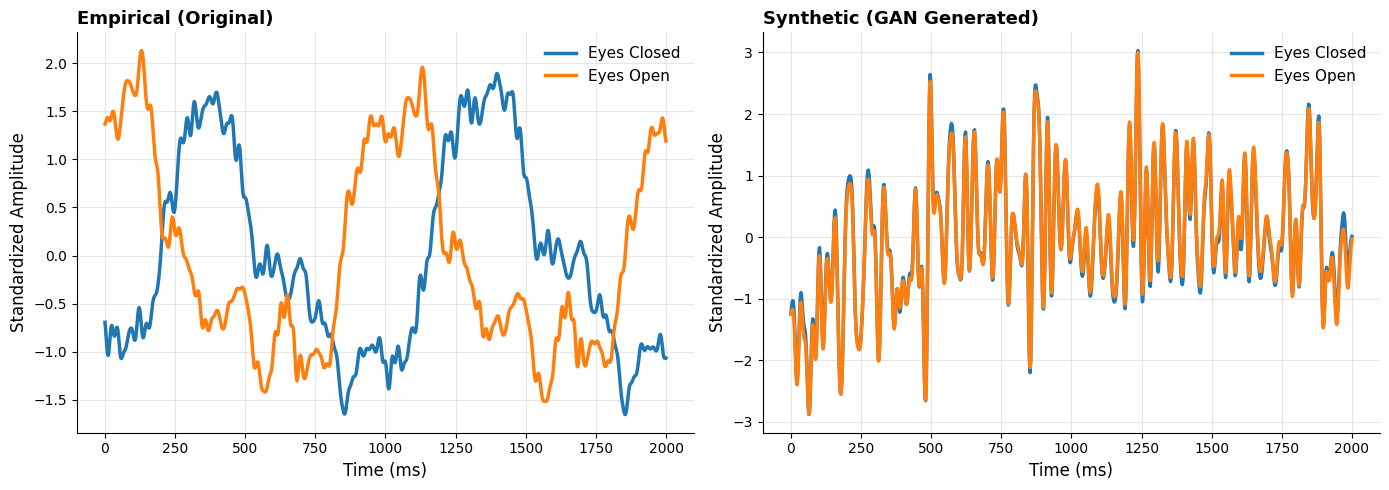

✓ Saved: grand_average_comparison.png

GRAND AVERAGE STATISTICS

Empirical:
  Eyes Closed: Mean=-0.0000, Std=0.0000
  Eyes Open:   Mean=0.0000, Std=0.0000
  Mean absolute difference: 0.0000

Synthetic (Filtered):
  Eyes Closed: Mean=-0.0155, Std=0.1017
  Eyes Open:   Mean=-0.0182, Std=0.1051
  Mean absolute difference: 0.0071

⚠️ Condition separation: 153376.3% of empirical

Correlation (Empirical vs Synthetic):
  Eyes Closed: r=0.054 (p=0.0859)
  Eyes Open:   r=-0.288 (p=0.0000)


In [34]:
# Grand average comparison
time_cols = [col for col in df.columns if col.startswith('Time')]

# Compute grand averages
emp_closed = df[df['Condition'] == 0][time_cols].mean(axis=0).values
emp_open = df[df['Condition'] == 1][time_cols].mean(axis=0).values

syn_closed = syntheticEEG[syntheticEEG[:, 0] == 0, syn_time_start:].mean(axis=0)
syn_open = syntheticEEG[syntheticEEG[:, 0] == 1, syn_time_start:].mean(axis=0)

# Plot comparison
f, axes = plt.subplots(1, 2, figsize=(14, 5))

# Empirical
axes[0].plot(time_ms, scale(emp_closed), label='Eyes Closed', linewidth=2.5, color='C0')
axes[0].plot(time_ms, scale(emp_open), label='Eyes Open', linewidth=2.5, color='C1')
axes[0].set_ylabel('Standardized Amplitude', fontsize=12)
axes[0].set_xlabel('Time (ms)', fontsize=12)
axes[0].set_title('Empirical (Original)', loc='left', fontweight='bold', fontsize=13)
axes[0].spines[['right', 'top']].set_visible(False)
axes[0].legend(frameon=False, fontsize=11)
axes[0].grid(alpha=0.3)

# Synthetic
axes[1].plot(time_ms, scale(syn_closed), label='Eyes Closed', linewidth=2.5, color='C0')
axes[1].plot(time_ms, scale(syn_open), label='Eyes Open', linewidth=2.5, color='C1')
axes[1].set_ylabel('Standardized Amplitude', fontsize=12)
axes[1].set_xlabel('Time (ms)', fontsize=12)
axes[1].set_title('Synthetic (GAN Generated)', loc='left', fontweight='bold', fontsize=13)
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].legend(frameon=False, fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('grand_average_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: grand_average_comparison.png")

# Statistics
from scipy.stats import pearsonr

print("\n" + "="*60)
print("GRAND AVERAGE STATISTICS")
print("="*60)
print("\nEmpirical:")
print(f"  Eyes Closed: Mean={emp_closed.mean():.4f}, Std={emp_closed.std():.4f}")
print(f"  Eyes Open:   Mean={emp_open.mean():.4f}, Std={emp_open.std():.4f}")
# ADD: Show difference between conditions
emp_diff = np.abs(emp_closed - emp_open).mean()
print(f"  Mean absolute difference: {emp_diff:.4f}")

print("\nSynthetic (Filtered):")
print(f"  Eyes Closed: Mean={syn_closed.mean():.4f}, Std={syn_closed.std():.4f}")
print(f"  Eyes Open:   Mean={syn_open.mean():.4f}, Std={syn_open.std():.4f}")
# ADD: Show difference between conditions
syn_diff = np.abs(syn_closed - syn_open).mean()
print(f"  Mean absolute difference: {syn_diff:.4f}")

# ADD: Ratio of synthetic to empirical difference
if emp_diff > 0:
    diff_ratio = syn_diff / emp_diff
    print(f"\n⚠️ Condition separation: {diff_ratio*100:.1f}% of empirical")
    if diff_ratio < 0.3:
        print("   → GAN is NOT learning condition differences well")
        print("   → Try training for MORE epochs (2000+)")
        print("   → Or increase autoencoder compression to preserve differences")

corr_closed, p_closed = pearsonr(scale(emp_closed), scale(syn_closed))
corr_open, p_open = pearsonr(scale(emp_open), scale(syn_open))
print("\nCorrelation (Empirical vs Synthetic):")
print(f"  Eyes Closed: r={corr_closed:.3f} (p={p_closed:.4f})")
print(f"  Eyes Open:   r={corr_open:.3f} (p={p_open:.4f})")
print("="*60)

Computing Power Spectral Density...


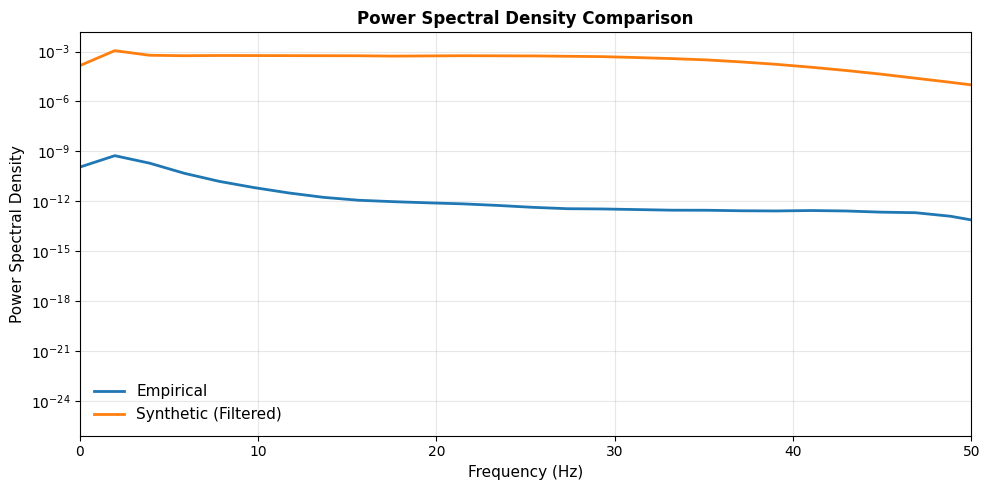

✓ Saved: psd_comparison.png

ANALYSIS COMPLETE!

Generated files:
  1. trial_comparison.png
  2. grand_average_comparison.png
  3. psd_comparison.png

You can now use the synthetic data for augmentation!


In [ ]:
# Power Spectral Density comparison
from scipy import signal as sig

def compute_psd(data, fs):
    """Compute average PSD across all samples"""
    psds = []
    for i in range(data.shape[0]):
        f, psd = sig.welch(data[i], fs=fs, nperseg=min(256, len(data[i])))
        psds.append(psd)
    return f, np.mean(psds, axis=0)

print("Computing Power Spectral Density...")
f_emp, psd_emp = compute_psd(df[time_cols].values, sfreq)
f_syn, psd_syn = compute_psd(syntheticEEG[:, syn_time_start:], sfreq)

plt.figure(figsize=(10, 5))
plt.semilogy(f_emp, psd_emp, label='Empirical', linewidth=2, color='C0')
plt.semilogy(f_syn, psd_syn, label='Synthetic (Filtered)', linewidth=2, color='C1')
plt.xlabel('Frequency (Hz)', fontsize=11)
plt.ylabel('Power Spectral Density', fontsize=11)
plt.title('Power Spectral Density Comparison', fontweight='bold', fontsize=12)
plt.legend(frameon=False, fontsize=11)
plt.xlim([0, 50])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('psd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: psd_comparison.png")

print("\n" + "="*60)
print("ANALYSIS COMPLETE!")
print("="*60)
print("\nGenerated files:")
print("  1. trial_comparison.png")
print("  2. grand_average_comparison.png")
print("  3. psd_comparison.png")
print("\nYou can now use the synthetic data for augmentation!")